# **DETECT ANOMALIES IN STOCK PRICES USING LONG SHORT-TERM MEMORY (LSTM)**
## Aim: 
*   LSTM model can be used for identifying anomalies in time-series data. In this model, we are going to analyze TESLA share prices (TSLA).
*   Anomaly is detected, when the deviation of the actual price from the predicted price of the model is higher than 1% of the historical mean absolute error (MAE) 

## Applications of Anomaly Detection:

*   Stock Trading: Use anomaly detection for trading strategies and risk management
*   Banks and Regulators: Spot fraudulent activities and insider trading
*   Likewise, this concept can also be applied in other fields such as detecting fraudulent credit card transactions, identifying equipment failures and medical diagnosis


### **(1) Fetch Real Stock Price Data**

In [112]:
# Import libraries
import pandas as pd
import plotly.express as pxa
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime
import yfinance as yf
from tensorflow import keras

In [113]:
# Download stock prices from 2015 to the current stock price from Yahoo Finance
ticker = ['TSLA']
df_prices = pd.DataFrame()

start_date = "2015-01-01"
end_date = datetime.date.today() # today's date
stock_prices = yf.download(ticker, start_date, end_date, progress = False)

stock_prices.columns = stock_prices.columns.droplevel(1)  # Drop the "Ticker" level

stock_prices = stock_prices.reset_index()
df_prices["Date"] = stock_prices["Date"]
df_prices["Close"] = stock_prices["Close"]
df_prices

,Date,Close
0,2015-01-02,14.620667
1,2015-01-05,14.006000
2,2015-01-06,14.085333
3,2015-01-07,14.063333
4,2015-01-08,14.041333
...,...,...
2555,2025-03-03,284.649994
2556,2025-03-04,272.040009
2557,2025-03-05,279.100006
2558,2025-03-06,263.450012


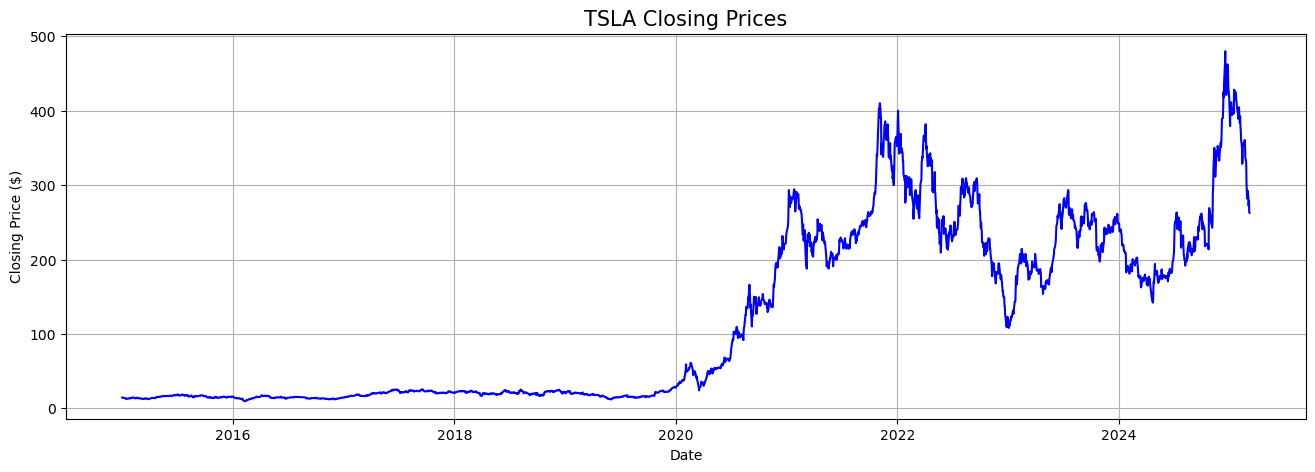

In [114]:
# Plot the line chart of the closing prices
plt.figure(figsize=(16, 5)) 
plt.plot(df_prices['Date'], df_prices["Close"], color='b')
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title(ticker[0] +" Closing Prices", size=15)

plt.grid(True)
plt.show()

### **(2) Normalize Stock Prices**

In [115]:
prices = df_prices[['Close']].values # get the closing prices in 2-D array
prices

array([[ 14.62066746],
       [ 14.00599957],
       [ 14.08533287],
       ...,
       [279.1000061 ],
       [263.45001221],
       [262.67001343]])

In [116]:
# Normalize stock prices between 0 and 1
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)
prices_scaled

array([[0.01072265],
       [0.00941563],
       [0.00958432],
       ...,
       [0.57310723],
       [0.53982934],
       [0.53817076]])

### **(3) Create Training and Testing Data**

In [117]:
# Create lists for features and target labels
X = [] # input features
y = [] # target labels

sequence_length = 50  # Use the past 50 stock prices to predict the next stock price
for i in range(sequence_length, len(prices_scaled)):
    X.append(prices_scaled[i-sequence_length:i, 0])
    y.append(prices_scaled[i, 0])

In [118]:
# Convert the data into array format
X = np.asarray(X)
y = np.asarray(y)

In [119]:
# Split the data into training (70%) and testing data (30%)
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [120]:
# Reshape the 1D arrays to 3D arrays for feeding into the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((1757, 50, 1), (753, 50, 1))

### **(4) Build LSTM Autoencoder**

In [121]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])) # Input layer

# set 150 neutrons for each LSTM layer with dropout rate of 0.3
x = keras.layers.LSTM(150, return_sequences= True)(inputs) # 1st layer
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x) # 2nd layer
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x) # Output layer
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 50, 150)             │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 50, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 50, 150)             │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,551 (1.73 MB)

 Trainable params: 452,551 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# Fitting the model with the training data
# Add EarlyStopping to prevent overfitting
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - loss: 2.9396e-04 - val_loss: 0.0284
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - loss: 0.0103 - val_loss: 0.0700
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 0.0137 - val_loss: 0.0503
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 0.0074 - val_loss: 0.0109
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 0.0161 - val_loss: 0.0068
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - loss: 0.0176 - val_loss: 0.0047
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - loss: 0.0098 - val_loss: 0.0027
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━

### **(5) Predict Stock Prices and Detect Anomalies**

In [123]:
# Make prediction of the training data
predicted_train = model.predict(X_train, verbose=0)
predicted_train.shape

(1757, 1)

In [124]:
# Reshape the prediction to 2D array for comparison
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  
X_train_reshaped.shape

(1757, 50)

Reconstruction error threshold:  0.16401771523410338


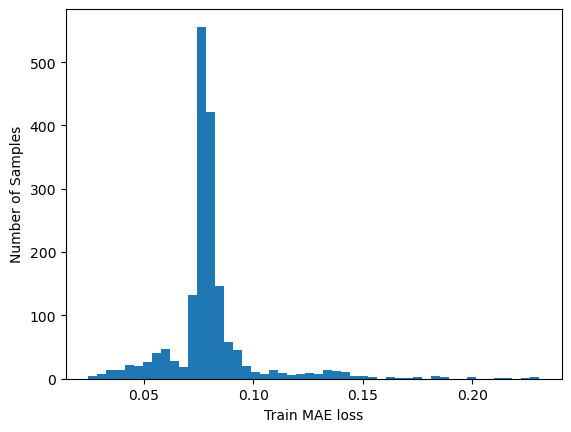

In [125]:
# Calculate the mean absolute error of the training data
train_mae_loss = np.mean(np.abs(predicted_train - X_train_reshaped), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.percentile(train_mae_loss, 99)  # Set the top 1% as anomalies
print("Reconstruction error threshold: ",threshold)

In [126]:
# Make prediction of the testing data
predicted_test = model.predict(X_test, verbose=0)
predicted_test.shape

(753, 1)

In [127]:
# Reshape the prediction to 2D array for comparison
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)  
X_test_reshaped.shape

(753, 50)

In [128]:
# Calculate the mean absolute error of the testing data
test_mae_loss = np.mean(np.abs(predicted_test-X_test_reshaped), axis=1)

Text(0, 0.5, 'Number of Samples')

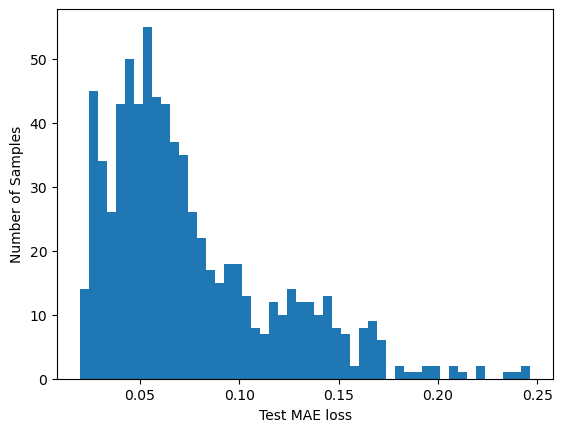

In [129]:
# Calculate the mean absolute error of the training data
test_mae_loss = np.mean(np.abs(predicted_test - X_test_reshaped), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples')

In [130]:
# Create a dataframe for storing the results of anomalies for the test data
test_anomaly = df_prices[split+sequence_length:][['Date']]
test_anomaly['Close'] = df_prices[split+sequence_length:]['Close']
test_anomaly['MAE_Loss'] = test_mae_loss
test_anomaly['Threshold'] = threshold
test_anomaly['Anomaly'] = test_anomaly['MAE_Loss'] > test_anomaly['Threshold'] # check whether a particular price is anomaly or not

test_anomaly

,Date,Close,MAE_Loss,Threshold,Anomaly
1807,2022-03-08,274.799988,0.075138,0.164018,False
1808,2022-03-09,286.323334,0.073266,0.164018,False
1809,2022-03-10,279.433319,0.069717,0.164018,False
1810,2022-03-11,265.116669,0.066693,0.164018,False
1811,2022-03-14,255.456665,0.065644,0.164018,False
...,...,...,...,...,...
2555,2025-03-03,284.649994,0.173543,0.164018,True
2556,2025-03-04,272.040009,0.182528,0.164018,True
2557,2025-03-05,279.100006,0.190051,0.164018,True
2558,2025-03-06,263.450012,0.195589,0.164018,True


In [131]:
# Extract the prices and dates with anomalies identified
anomalies = test_anomaly.loc[test_anomaly['Anomaly'] == True]
anomalies

,Date,Close,MAE_Loss,Threshold,Anomaly
2129,2023-06-20,274.450012,0.164936,0.164018,True
2130,2023-06-21,259.459991,0.169992,0.164018,True
2131,2023-06-22,264.609985,0.172019,0.164018,True
2132,2023-06-23,256.600006,0.172074,0.164018,True
2133,2023-06-26,241.050003,0.169002,0.164018,True
2396,2024-07-12,248.229996,0.165481,0.164018,True
2397,2024-07-15,252.639999,0.166584,0.164018,True
2398,2024-07-16,256.559998,0.164278,0.164018,True
2486,2024-11-18,338.739990,0.165814,0.164018,True
2487,2024-11-19,346.000000,0.167796,0.164018,True


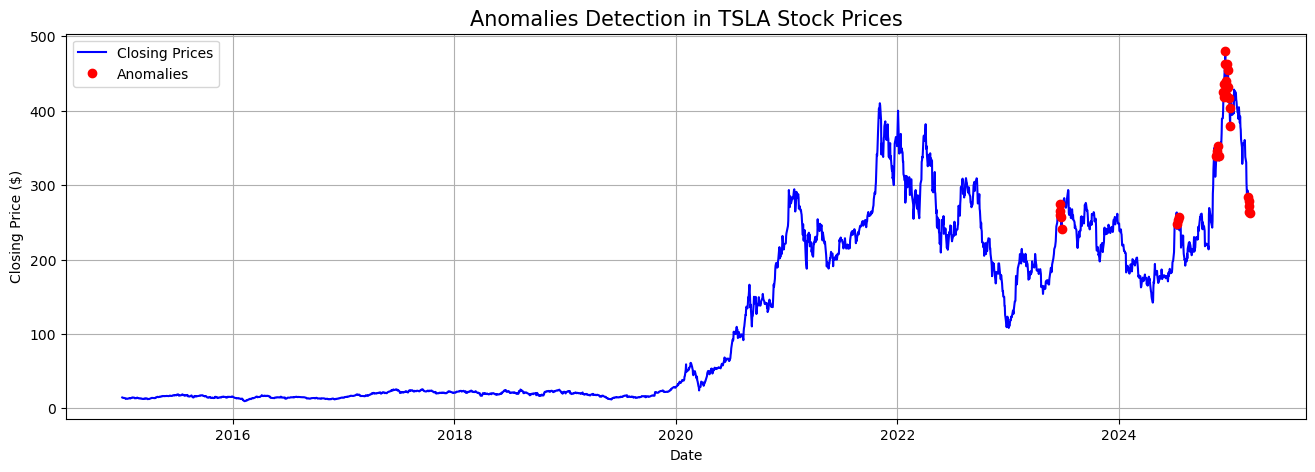

In [132]:
# Plot the line chart of the closing prices with discrete dots
plt.figure(figsize=(16, 5)) 

# Plot the main data points as discrete dots
plt.plot(df_prices['Date'], df_prices["Close"], marker='', color='b', linestyle='-', label='Closing Prices')

# Plot the anomalies as red dots
plt.plot(anomalies['Date'], anomalies["Close"], marker='o', color='r', linestyle='', label='Anomalies')

# Labels and title
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title("Anomalies Detection in " + ticker[0] + " Stock Prices", size=15)

plt.grid(True)
plt.legend()
plt.show()

### **(6) Model Evaluation**

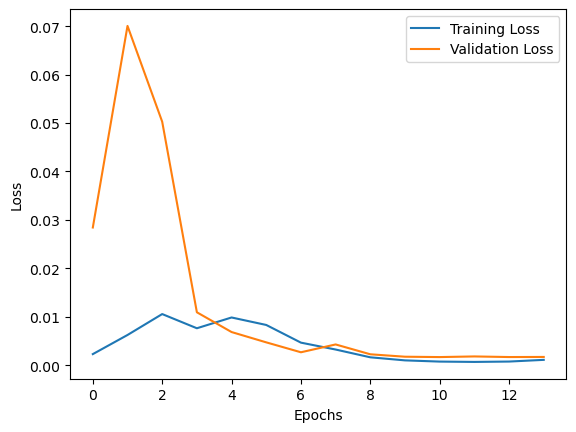

In [133]:
# Plot the graphs of training loss and validation loss
# Both curves show a steady decline in loss and coverage to the min, a sign of good generalization of the LSTM model
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [134]:
# Calculate the MAE and RMSE of the predicted values of the test dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(predicted_test.reshape(-1), y_test.reshape(-1)) # flatten the arrays for calculations
print("Mean Absolute Error (MAE):", mae)

rmse = np.sqrt(mean_squared_error(predicted_test.reshape(-1), y_test.reshape(-1)))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.03914050565799119
Root Mean Squared Error (RMSE): 0.04634700157896303


**Conclusion: The model is well-trained with great generalization, proven by:**
- the training and validation loss curves which decrease smoothly and converge near zero, and
- the low MAE and RMSE, indicating that the model makes small prediction errors

### **(7) Insights**


Here are the anomalies found by the model, which are in-line with the actual price movement during the same period.


**Jun-Jul 2023**: TSLA shares surged by nearly 30% month-on-month in June 2023, on the back of AI and EV (Electric Vehicle) market growth and its strong deliveries.

**Nov 2024**: Share prices surged on optimism of Donald Trump's election victory.

**Dec 2024**: After TSLA shares reached its all-time high on 17th Decemeber 2024, the shares plunged, due to weak market sentiment on trade tariffs by the US as well as TESLA's declining sales data.

**Mar 2025**: Shares extended further losses, amid market concerns over Elon Musk’s involvement with the Trump administration as well as the falling new vehicle sales.

**By identifying anomalies in the stock prices, traders may profit from the temporary price discrepancies due to arbitrage.**